### Setup

In [1]:
import os, sys
HOME = os.environ['HOME']  # change if necessary
sys.path.append(f'{HOME}/Finite-groups/src')

In [2]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
from irrep_bounds import *
from bound_utils import *
%load_ext autoreload
%autoreload 2

Syntax warning: Unbound global variable in /usr/share/gap/pkg/browse/PackageIn\
fo.g:73
  if not IsKernelExtensionAvailable("Browse", "ncurses") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/edim/PackageInfo\
.g:60
  if not IsKernelExtensionAvailable("EDIM","ediv") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^


In [3]:

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# MODEL_DIR = '2024-08-16_22-53-29_SL2_5_MLP3_256'
# MODEL_DIR = '2024-08-14_21-24-30_gapS_5_'
MODEL_DIR = '2024-09-18_23-59-00_gapS5_MLP2_128_wd2e-4_ubias'
# MODEL_DIR = '2024-09-19_02-28-43_gapS5_MLP2_128_wd1e-4_ubias'
# MODEL_DIR = '2024-09-18_05-50-44_gapS5_MLP2_128_wd1e-5_ubias'
# MODEL_DIR = '2024-09-16_05-00-33_gapS5_MLP2_128_adamw_wd1'
# MODEL_DIR = '2024-09-13_03-46-47_gapS5_256_wd1e-3'
# MODEL_DIR = '2024-09-13_21-56-07_gapS5_MLP2_256_adamw_wd1'
# MODEL_DIR = '2024-08-27_16-32-46_Dic30_MLP3_128'
# MODEL_DIR = '2024-08-27_23-16-05_F11_MLP3_256'
# MODEL_DIR = '2024-09-02_18-17-20_smallgrp_54_8_MLP3_256_0_6'
# MODEL_DIR = '2024-09-05_15-22-58_smallgrp_54_8_MLP3_1024_0_6'
# MODEL_DIR = '2024-09-05_20-47-44_smallgrp_54_8_MLP3_1024_0_6_wd1e-6'
# MODEL_DIR = '2024-09-02_18-51-29_smallgrp_96_71_MLP3_256_0_6'
# MODEL_DIR = '2024-09-03_17-28-20_smallgrp_192_1025_MLP3_512_0_6'
# MODEL_DIR = '2024-09-03_21-09-07_Z_59_128'
disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
if not os.path.exists(local_dir):
    snapshot_download(repo_id=f'wiwu2390/{MODEL_DIR}', local_dir=local_dir)
models, params = load_models(local_dir)
models = models[-1]  # get last checkpoint
data = GroupData(params)
group = data.groups[0]

Intersection size: 14400/14400 (1.00)
Added 14400 elements from intersection
Added 0 elements from group 0: gapS(5)
Taking random subset: 5760/14400 (0.40)
Train set size: 5760/14400 (0.40)


/home/wilson/Finite-groups/src/model_utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


In [4]:
lin_irrep_times = []
lin_irrep_accs = []
quad_irrep_times = []
quad_irrep_accs = []
naive_times = []
naive_accs = []
for instance in tqdm(range(len(models))):
    model = models[instance]
    naive_acc, naive_time = naive_acc_bound(model, group)
    naive_times.append(naive_time)
    naive_accs.append(naive_acc)
    
    irreps, irrep_idx_dict = get_neuron_irreps(model, group, norm_thresh=1)
    vecs = get_neuron_vecs(model, group, irreps, irrep_idx_dict, strict=False)
    # irrep_acc_lin, irrep_time_lin = irrep_acc_bound(model, group, irreps, irrep_idx_dict, vecs, linear=True)
    irrep_acc_quad, irrep_time_quad = irrep_acc_bound(model, group, irreps, irrep_idx_dict, vecs, linear=False)
    # lin_irrep_accs.append(irrep_acc_lin)
    # lin_irrep_times.append(irrep_time_lin)
    quad_irrep_accs.append(irrep_acc_quad)
    quad_irrep_times.append(irrep_time_quad)
    print('brute', naive_acc, naive_time)
    # print('lin', irrep_acc_lin, irrep_time_lin)
    print('quad', irrep_acc_quad, irrep_time_quad)

  1%|          | 1/100 [00:07<11:46,  7.14s/it]

brute 1.0 2.7910900115966797
quad 1.0 0.7999892234802246


  2%|▏         | 2/100 [00:13<11:11,  6.85s/it]

brute 1.0 2.3213558197021484
quad 0.7599999904632568 0.802532434463501


  3%|▎         | 3/100 [00:19<10:18,  6.38s/it]

brute 1.0 2.302795886993408
quad 1.0 0.8064696788787842


  4%|▍         | 4/100 [00:25<09:51,  6.16s/it]

brute 1.0 2.3178515434265137
quad 1.0 0.7944741249084473


  5%|▌         | 5/100 [00:35<11:50,  7.48s/it]

brute 1.0 2.4159657955169678
quad 0.0 1.0961105823516846


  6%|▌         | 6/100 [00:49<15:08,  9.67s/it]

Not permutation on b!!!
brute 1.0 2.3945844173431396
quad 0.0 1.0395326614379883


  7%|▋         | 7/100 [00:55<13:15,  8.55s/it]

brute 1.0 2.389535427093506
quad 1.0 0.8461086750030518


  8%|▊         | 8/100 [01:01<11:56,  7.78s/it]

brute 1.0 2.312690019607544
quad 1.0 0.8156266212463379


  9%|▉         | 9/100 [01:07<11:04,  7.31s/it]

brute 1.0 2.3220772743225098
quad 1.0 1.0025599002838135


 10%|█         | 10/100 [01:15<11:10,  7.45s/it]

brute 1.0 2.313790798187256
quad 0.7500694394111633 1.0351932048797607


 11%|█         | 11/100 [01:21<10:31,  7.09s/it]

brute 1.0 2.321913719177246
quad 1.0 0.8428597450256348


 12%|█▏        | 12/100 [01:28<10:00,  6.82s/it]

brute 1.0 2.32651424407959
quad 0.0 0.7966470718383789


 13%|█▎        | 13/100 [01:34<09:33,  6.59s/it]

brute 1.0 2.349046468734741
quad 1.0 0.820030927658081


 14%|█▍        | 14/100 [01:43<10:47,  7.53s/it]

Not permutation on b!!!
brute 1.0 2.3147060871124268
quad 0.0 0.801177978515625


 15%|█▌        | 15/100 [01:49<09:57,  7.03s/it]

brute 1.0 2.360316276550293
quad 0.0 0.8150315284729004


 16%|█▌        | 16/100 [01:58<10:24,  7.43s/it]

brute 1.0 2.3471319675445557
quad 0.0 0.8494107723236084


 17%|█▋        | 17/100 [02:04<09:54,  7.16s/it]

brute 1.0 2.760653495788574
quad 1.0 0.8383519649505615


 18%|█▊        | 18/100 [02:12<09:59,  7.31s/it]

brute 1.0 2.35025954246521
quad 0.7664583325386047 0.8206636905670166


 19%|█▉        | 19/100 [02:18<09:24,  6.97s/it]

brute 1.0 2.336956739425659
quad 1.0 0.8166177272796631


 20%|██        | 20/100 [02:28<10:28,  7.86s/it]

brute 1.0 2.352696418762207
quad 0.0 0.837470531463623


 21%|██        | 21/100 [02:34<09:45,  7.41s/it]

brute 1.0 2.4656403064727783
quad 1.0 0.8451035022735596


 22%|██▏       | 22/100 [02:43<10:13,  7.86s/it]

brute 1.0 2.3909966945648193
quad 0.0 0.9766790866851807


 23%|██▎       | 23/100 [02:51<10:13,  7.97s/it]

brute 1.0 2.2894387245178223
quad 0.0050694444216787815 0.8314037322998047


 24%|██▍       | 24/100 [03:03<11:18,  8.92s/it]

Not permutation on b!!!
brute 0.9998611111111111 2.324512481689453
quad 0.0 1.0544636249542236


 25%|██▌       | 25/100 [03:09<10:07,  8.10s/it]

brute 1.0 2.2557501792907715
quad 1.0 0.8531062602996826


 26%|██▌       | 26/100 [03:17<10:07,  8.21s/it]

brute 1.0 2.31919264793396
quad 0.0 0.8230228424072266


 27%|██▋       | 27/100 [03:23<09:03,  7.44s/it]

brute 1.0 2.277153491973877
quad 1.0 0.7910182476043701


 28%|██▊       | 28/100 [03:33<09:50,  8.20s/it]

brute 0.9995833333333334 2.3139071464538574
quad 0.0 1.0587644577026367


 29%|██▉       | 29/100 [03:45<11:16,  9.53s/it]

Not permutation on b!!!
brute 1.0 2.301622152328491
quad 0.0 1.0869641304016113


 30%|███       | 30/100 [03:54<10:46,  9.23s/it]

Not permutation on b!!!
brute 1.0 2.2845914363861084
quad 0.0 1.0269901752471924


 31%|███       | 31/100 [04:00<09:32,  8.30s/it]

brute 1.0 2.3398377895355225
quad 1.0 0.7935645580291748


 32%|███▏      | 32/100 [04:10<09:53,  8.73s/it]

brute 1.0 2.2647030353546143
quad 0.0 0.8454711437225342


 33%|███▎      | 33/100 [04:16<08:43,  7.82s/it]

brute 1.0 2.2943944931030273
quad 1.0 0.8079779148101807


 34%|███▍      | 34/100 [04:25<09:04,  8.24s/it]

brute 1.0 2.2708184719085693
quad 0.0 1.1089975833892822


 35%|███▌      | 35/100 [04:31<08:14,  7.61s/it]

brute 1.0 2.285414218902588
quad 1.0 0.8243844509124756


 36%|███▌      | 36/100 [04:41<08:49,  8.28s/it]

brute 1.0 2.3700921535491943
quad 0.0 0.8863720893859863


 37%|███▋      | 37/100 [04:47<08:07,  7.73s/it]

brute 1.0 2.305262565612793
quad 0.4050694406032562 0.8010127544403076


 38%|███▊      | 38/100 [04:53<07:21,  7.13s/it]

brute 1.0 2.2923941612243652
quad 1.0 0.7865440845489502


 39%|███▉      | 39/100 [05:07<09:15,  9.11s/it]

Not permutation on b!!!
brute 1.0 2.2778468132019043
quad 0.0 1.084096908569336


 40%|████      | 40/100 [05:12<08:05,  8.09s/it]

brute 1.0 2.2981083393096924
quad 1.0 0.86173415184021


 41%|████      | 41/100 [05:18<07:14,  7.36s/it]

brute 1.0 2.2814252376556396
quad 1.0 0.7894437313079834


 42%|████▏     | 42/100 [05:24<06:39,  6.88s/it]

brute 1.0 2.3070859909057617
quad 1.0 0.7955915927886963


 43%|████▎     | 43/100 [05:30<06:24,  6.74s/it]

brute 1.0 2.3802859783172607
quad 1.0 0.8112587928771973


 44%|████▍     | 44/100 [05:36<06:08,  6.58s/it]

brute 1.0 2.325326681137085
quad 1.0 0.8632760047912598


 45%|████▌     | 45/100 [05:44<06:11,  6.75s/it]

brute 1.0 2.3312838077545166
quad 0.0 0.8359375


 46%|████▌     | 46/100 [05:51<06:18,  7.00s/it]

brute 1.0 2.320052146911621
quad 0.0 0.7925455570220947


 47%|████▋     | 47/100 [05:57<05:51,  6.63s/it]

brute 1.0 2.271616220474243
quad 1.0 0.8918063640594482


 48%|████▊     | 48/100 [06:04<05:59,  6.91s/it]

brute 1.0 2.3797786235809326
quad 0.0 0.8098044395446777


 49%|████▉     | 49/100 [06:11<05:41,  6.71s/it]

brute 1.0 2.3654515743255615
quad 1.0 0.8809058666229248


 50%|█████     | 50/100 [06:22<06:45,  8.10s/it]

Not permutation on b!!!
brute 1.0 2.445077896118164
quad 0.0 1.0998122692108154


 51%|█████     | 51/100 [06:33<07:22,  9.02s/it]

brute 1.0 2.3172645568847656
quad 0.0 1.0745153427124023


 52%|█████▏    | 52/100 [06:39<06:29,  8.11s/it]

brute 1.0 2.3201117515563965
quad 1.0 0.9216310977935791


 53%|█████▎    | 53/100 [06:47<06:10,  7.88s/it]

brute 1.0 2.334836483001709
quad 0.0 0.829662561416626


 54%|█████▍    | 54/100 [06:53<05:37,  7.33s/it]

brute 1.0 2.3130686283111572
quad 1.0 0.7995648384094238


 55%|█████▌    | 55/100 [07:07<07:07,  9.50s/it]

Not permutation on b!!!
brute 1.0 2.3362526893615723
quad 0.0 1.3128702640533447


 56%|█████▌    | 56/100 [07:21<07:55, 10.80s/it]

brute 1.0 2.3450589179992676
quad 0.0 1.0610771179199219


 57%|█████▋    | 57/100 [07:32<07:47, 10.87s/it]

Not permutation on b!!!
brute 0.9975 2.397858142852783
quad 0.0 1.0687239170074463


 58%|█████▊    | 58/100 [07:40<06:58,  9.96s/it]

brute 1.0 2.274367094039917
quad 0.7599999904632568 0.8225057125091553


 59%|█████▉    | 59/100 [07:45<05:54,  8.64s/it]

brute 1.0 2.300992250442505
quad 1.0 0.805152177810669


 60%|██████    | 60/100 [07:51<05:13,  7.83s/it]

brute 1.0 2.273555040359497
quad 1.0 0.9839611053466797


 61%|██████    | 61/100 [07:57<04:39,  7.16s/it]

brute 1.0 2.292166233062744
quad 1.0 0.786635160446167


 62%|██████▏   | 62/100 [08:03<04:19,  6.84s/it]

brute 1.0 2.2961981296539307
quad 1.0 0.8114364147186279


 63%|██████▎   | 63/100 [08:12<04:31,  7.34s/it]

brute 1.0 2.310702085494995
quad 0.0 0.7914326190948486


 64%|██████▍   | 64/100 [08:21<04:49,  8.04s/it]

brute 1.0 2.3399791717529297
quad 0.0 0.7898027896881104


 65%|██████▌   | 65/100 [08:32<05:07,  8.78s/it]

Not permutation on b!!!
brute 1.0 2.284442186355591
quad 0.0 1.025519609451294


 66%|██████▌   | 66/100 [08:42<05:17,  9.33s/it]

Not permutation on b!!!
brute 1.0 2.293687343597412
quad 0.0 1.0177662372589111


 67%|██████▋   | 67/100 [08:48<04:32,  8.25s/it]

brute 1.0 2.31207537651062
quad 1.0 0.7901678085327148


 68%|██████▊   | 68/100 [08:54<03:59,  7.50s/it]

brute 1.0 2.3145346641540527
quad 0.9973611235618591 0.7872354984283447


 69%|██████▉   | 69/100 [09:00<03:42,  7.18s/it]

brute 1.0 2.323138475418091
quad 0.7599999904632568 0.8014047145843506


 70%|███████   | 70/100 [09:10<03:54,  7.81s/it]

Not permutation on b!!!
brute 1.0 2.329040288925171
quad 0.0 0.7905192375183105


 71%|███████   | 71/100 [09:16<03:30,  7.27s/it]

brute 1.0 2.253025770187378
quad 1.0 0.8196730613708496


 72%|███████▏  | 72/100 [09:25<03:40,  7.88s/it]

brute 1.0 2.2482998371124268
quad 0.0 1.21171236038208


 73%|███████▎  | 73/100 [09:33<03:38,  8.11s/it]

brute 1.0 2.326066017150879
quad 0.0 1.034200668334961


 74%|███████▍  | 74/100 [09:43<03:40,  8.46s/it]

brute 1.0 2.2846429347991943
quad 0.0 0.8255670070648193


 75%|███████▌  | 75/100 [09:48<03:10,  7.62s/it]

brute 1.0 2.288001298904419
quad 1.0 0.7834110260009766


 76%|███████▌  | 76/100 [09:59<03:26,  8.62s/it]

brute 1.0 2.273439645767212
quad 0.0 1.0498764514923096


 77%|███████▋  | 77/100 [10:06<03:07,  8.14s/it]

brute 1.0 2.2708985805511475
quad 0.0 0.7907764911651611


 78%|███████▊  | 78/100 [10:17<03:15,  8.90s/it]

brute 0.9995833333333334 2.3400557041168213
quad 0.0 1.0452516078948975


 79%|███████▉  | 79/100 [10:23<02:47,  7.96s/it]

brute 1.0 2.291508436203003
quad 1.0 0.7918727397918701


 80%|████████  | 80/100 [10:35<03:02,  9.12s/it]

brute 1.0 2.304863214492798
quad 0.0 1.1274378299713135


 81%|████████  | 81/100 [10:47<03:14, 10.23s/it]

Not permutation on b!!!
brute 0.9997916666666666 2.291536569595337
quad 0.0 1.0498101711273193


 82%|████████▏ | 82/100 [10:55<02:49,  9.41s/it]

brute 1.0 2.27868914604187
quad 0.9527083039283752 0.7940413951873779


 83%|████████▎ | 83/100 [11:01<02:22,  8.39s/it]

brute 1.0 2.39719295501709
quad 1.0 0.8858752250671387


 84%|████████▍ | 84/100 [11:07<02:04,  7.79s/it]

brute 1.0 2.3249406814575195
quad 1.0 0.842332124710083


 85%|████████▌ | 85/100 [11:14<01:50,  7.37s/it]

brute 1.0 2.403362989425659
quad 1.0 0.8137032985687256


 86%|████████▌ | 86/100 [11:20<01:36,  6.89s/it]

brute 1.0 2.2991926670074463
quad 1.0 0.7918088436126709


 87%|████████▋ | 87/100 [11:26<01:27,  6.71s/it]

brute 1.0 2.3616766929626465
quad 1.0 0.7901430130004883


 88%|████████▊ | 88/100 [11:32<01:17,  6.42s/it]

brute 1.0 2.344477415084839
quad 1.0 0.7935812473297119


 89%|████████▉ | 89/100 [11:37<01:08,  6.22s/it]

brute 1.0 2.27424693107605
quad 1.0 0.7886707782745361


 90%|█████████ | 90/100 [11:50<01:21,  8.15s/it]

Not permutation on b!!!
brute 1.0 2.3065500259399414
quad 0.0 1.0379762649536133


 91%|█████████ | 91/100 [11:56<01:07,  7.45s/it]

brute 1.0 2.325533866882324
quad 1.0 0.7959434986114502


 92%|█████████▏| 92/100 [12:03<00:59,  7.41s/it]

brute 1.0 2.3536670207977295
quad 0.0 0.7967240810394287


 93%|█████████▎| 93/100 [12:13<00:57,  8.24s/it]

brute 0.9999305555555555 2.29113507270813
quad 0.0 1.0366528034210205


 94%|█████████▍| 94/100 [12:19<00:45,  7.61s/it]

brute 1.0 2.309635639190674
quad 1.0 0.904688835144043


 95%|█████████▌| 95/100 [12:30<00:41,  8.40s/it]

Not permutation on b!!!
brute 1.0 2.2923240661621094
quad 0.0 0.8122427463531494


 96%|█████████▌| 96/100 [12:39<00:34,  8.61s/it]

brute 1.0 2.2744040489196777
quad 0.0 0.8075845241546631


 97%|█████████▋| 97/100 [12:45<00:23,  7.77s/it]

brute 1.0 2.3449482917785645
quad 1.0 0.8217353820800781


 98%|█████████▊| 98/100 [12:52<00:15,  7.67s/it]

brute 1.0 2.3684072494506836
quad 0.0 1.0283472537994385


 99%|█████████▉| 99/100 [13:00<00:07,  7.75s/it]

brute 1.0 2.3342642784118652
quad 0.0 0.7922065258026123


100%|██████████| 100/100 [13:06<00:00,  7.86s/it]

brute 1.0 2.3467371463775635
quad 1.0 0.7842004299163818


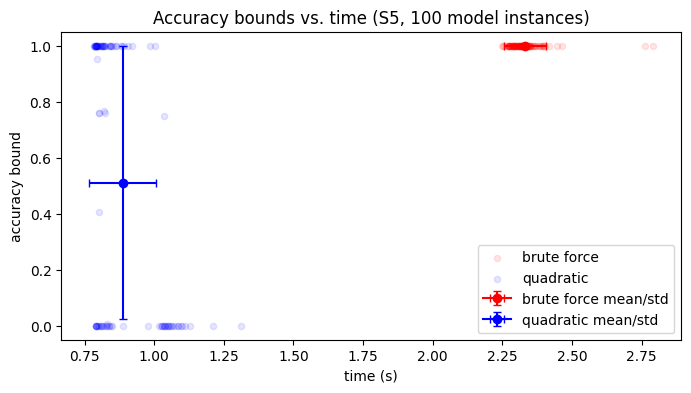

In [5]:
plt.figure(figsize=(8, 4))
plt.scatter(naive_times, naive_accs, label='brute force', alpha=0.1, color='red', s=20)
# plt.scatter(lin_irrep_times, lin_irrep_accs, label='linear', alpha=0.3, color='green', s=20)
plt.scatter(quad_irrep_times, quad_irrep_accs, label='quadratic', alpha=0.1, color='blue', s=20)
plt.errorbar([np.mean(naive_times)], [np.mean(naive_accs)], xerr=np.std(naive_times), yerr=np.std(naive_accs), label='brute force mean/std', color='red', marker='o', capsize=3)#, s=40)
# plt.errorbar([np.mean(lin_irrep_times)], [np.mean(lin_irrep_accs)], xerr=np.std(lin_irrep_times), yerr=np.std(lin_irrep_accs), label='linear mean/std', color='green', marker='o')#, s=40)
plt.errorbar([np.mean(quad_irrep_times)], [np.mean(quad_irrep_accs)], xerr=np.std(quad_irrep_times), yerr=np.std(quad_irrep_accs), label='quadratic mean/std', color='blue', marker='o', capsize=3)#, s=40)
plt.xlabel('time (s)')
plt.ylabel('accuracy bound')
plt.title('Accuracy bounds vs. time (S5, 100 model instances)')
plt.legend()
plt.savefig('../figs/acc_bound.png')
plt.show()

In [13]:
np.mean(irrep_accs)

np.float64(0.85)

In [6]:
t.save((naive_times, naive_accs, quad_irrep_times, quad_irrep_accs), '../data/acc_bound.pt')

In [4]:
loss_dict = test_loss(models.to(device), data)

In [5]:

# instance = loss_dict['G0_acc'].argmax().item()
instance = loss_dict['G0_loss'].argmin().item()
# instance = (loss_dict['G0_acc'] > 0.999).nonzero()[11]
# instance = 2
print(loss_dict[f'G0_loss'][instance], loss_dict[f'G0_acc'][instance], instance)
model = models[instance].to(device)

tensor(0.0306) tensor(1.) 12


In [6]:
norm12 = lambda A: A.norm(dim=0).max()  # max 2-norm along group dimension
# note: norm2inf in the correct one to use for both embed and unembed. bc of how the transposes work
norm2inf = lambda A: A.norm(dim=1).max()  # max 2-norm along neuron dimension
norm22 = lambda A: t.linalg.matrix_norm(A, ord=2)

ln, rn, un = model.get_neurons(True)

In [7]:
irreps, irrep_idx_dict = get_neuron_irreps(model, group, norm_thresh=1)

In [8]:
sign = irreps['1d-0'].squeeze(-1)
sign = sign / sign.norm()
proj = t.eye(120) - sign @ sign.T

In [9]:
vecs = get_neuron_vecs(model, group, irreps, irrep_idx_dict, strict=False)

1d-0
1-r2 90th percentile 0.0
a variance: 0.0
b variance: 1.0
c variance: 1.0
d variance: 0.0
a vs d tensor(0.)
2 0.0
2 0.0
b has 2 clusters with total loss 0.0
c has 2 clusters with total loss 0.0
b_parts [[0, 1]]
c_parts [[0, 1]]
a_mean tensor([1.])
b_mean tensor([[-1.],
        [ 1.]])
c_mean tensor([[-1.],
        [ 1.]])
dict_keys(['1d-0'])

4d-0
5d-0
6d-0
5d-1
4d-1
1-r2 90th percentile 0.0003428685595281422
a variance: 1.0489316792927639e-07
b variance: 0.9999996423721313
c variance: 0.9999998211860657
d variance: 8.395662121074565e-08
a vs d tensor(4.6905e-07)
2 2250.027587890625
3 1500.0555419921875
4 750.083984375
2 2250.039794921875
3 1500.080322265625
4 750.1212768554688
b has 5 clusters with total loss 0.11231589317321777
c has 5 clusters with total loss 0.16189686954021454
b_parts [[0, 1, 2, 3, 4]]
c_parts [[0, 1, 2, 3, 4]]
a_mean tensor([ 0.3751,  0.3751, -0.2517, -0.8095])
b_mean tensor([[ 0.1688, -0.0747, -0.9253,  0.3312],
        [-0.7629, -0.5941,  0.0941, -0.2371],


In [10]:
coef, A_norm, a_mean, b_mean, c_mean, b_labels, c_labels, b_parts, c_parts, bias_coef = vecs['4d-1']

In [11]:
ideal = get_idealized_model(model, irreps, irrep_idx_dict, vecs)

1d-0
l diff tensor(1.8304e-05)
r diff tensor(1.3973e-05)
u diff tensor(0.0017)
4d-1
l diff tensor(2.6048e-05)
r diff tensor(2.6962e-05)
u diff tensor(0.0022)
total
l 1-r2 tensor(3.9443e-05)
r 1-r2 tensor(3.9808e-05)
u 1-r2 tensor(0.0022)
bias 1-r2 tensor(0.0165)


In [12]:
ln, rn, un = model.get_neurons(True)
ubias = model.unembed_bias.detach().T
ln_ideal, rn_ideal, un_ideal = ideal.get_neurons(True)
ubias_ideal = ideal.unembed_bias.detach().T

In [13]:
test_loss(ideal, data), test_loss(model, data)

({'G0_loss': tensor([0.0273]), 'G0_acc': tensor([1.])},
 {'G0_loss': tensor([0.0306]), 'G0_acc': tensor([1.])})

In [14]:
model_dist(model, ideal, 2)

l diff tensor(0.1433)
r diff tensor(0.1450)
u diff tensor(0.4076)
l norm tensor(17.6622)
r norm tensor(17.6451)
u norm tensor(9.5807)
u diff term tensor(14.3321)
e diff term tensor(2.7619)
bias diff term tensor(1.2439)


tensor(18.3379)

In [15]:
model_dist(model, ideal, 'inf')

l diff tensor(0.1433)
r diff tensor(0.1450)
u diff tensor(0.2368)
l norm tensor(17.6622)
r norm tensor(17.6451)
u norm tensor(2.7431)
u diff term tensor(8.3253)
e diff term tensor(0.7908)
bias diff term tensor(0.4192)


tensor(9.5353)

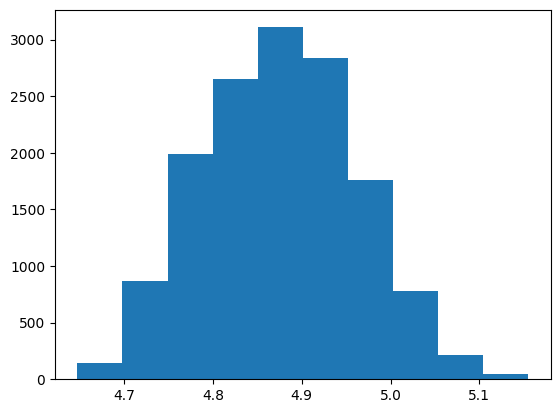

In [16]:
plt.hist(model_dist_xy(model, ideal, 'inf'))
plt.show()

(array([1.900e+01, 1.310e+02, 7.480e+02, 2.426e+03, 4.256e+03, 5.373e+03,
        1.057e+03, 3.280e+02, 5.900e+01, 3.000e+00]),
 array([5.8213625 , 5.82136459, 5.82136669, 5.82136879, 5.82137089,
        5.82137299, 5.82137508, 5.82137718, 5.82137928, 5.82138138,
        5.82138348]),
 <BarContainer object of 10 artists>)

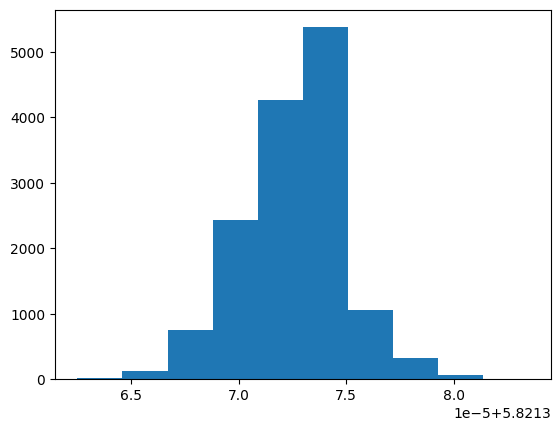

In [17]:
margins = []
for i, j in product(range(len(group)), repeat=2):
    out = ideal(t.tensor([[i, j]])).flatten()
    top2 = out.topk(k=2).values
    margins.append((top2[0] - top2[1]).item())
plt.hist(margins)

In [18]:
np.std(margins)

np.float64(2.4441744885394855e-06)

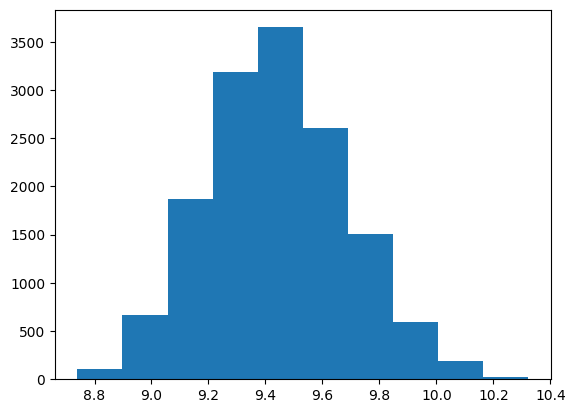

In [19]:
plt.hist(model_dist_xy(model, ideal, 2))
plt.show()

In [10]:
naive_acc_bound(model, group)

(1.0, 2.4458649158477783)

In [28]:
irrep_acc_bound(model, group, irreps, irrep_idx_dict, vecs)

[0, 1, 2, 3, 4] coef_sum tensor([6.8483, 6.8587, 6.7948, 6.8290, 6.8086, 6.8145, 6.8135, 6.8671, 6.7878,
        6.8544, 6.8364, 6.8867, 6.7939, 6.8766, 6.8363, 6.8558, 6.8340, 6.8829,
        6.8353, 6.8270, 6.8286, 6.7917, 6.8262, 6.8689, 6.8261])
[0, 1, 2, 3, 4] coef_mean tensor(6.8353)
1d-0
l diff tensor(1.8304e-05)
r diff tensor(1.3973e-05)
u diff tensor(0.0017)
4d-1
l diff tensor(2.6048e-05)
r diff tensor(2.6962e-05)
u diff tensor(0.0022)
total
l 1-r2 tensor(3.9443e-05)
r 1-r2 tensor(3.9808e-05)
u 1-r2 tensor(0.0022)
bias 1-r2 tensor(0.0165)


(1.0, 0.9154651165008545)

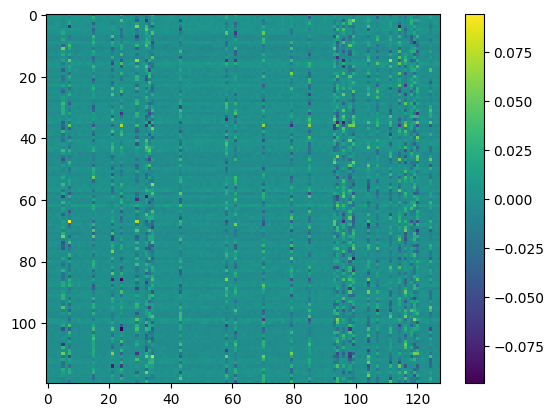

In [19]:
plt.imshow(un - un_ideal)
plt.colorbar()
plt.show()

In [51]:
((un - un_ideal).norm(dim=0) > 0.2).nonzero().flatten()

tensor([  5,   7,  15,  21,  24,  29,  32,  33,  34,  43,  58,  61,  70,  79,
         85,  93,  94,  96,  98,  99, 104, 111, 114, 116, 119, 120, 124])

In [44]:
ures_big = (un - un_ideal)[:, ((un - un_ideal).norm(dim=0) > 0.2).nonzero().flatten()]

In [47]:
t.svd(ures_big)[1]

tensor([0.4051, 0.3782, 0.3594, 0.3562, 0.3440, 0.3319, 0.3236, 0.2999, 0.2909,
        0.2836, 0.2738, 0.2672, 0.2515, 0.2417, 0.2181, 0.2094, 0.2019, 0.1956,
        0.1833, 0.1678, 0.1517, 0.1373, 0.1306, 0.1269, 0.1207, 0.1134, 0.0913])

In [42]:
7 in irrep_idx_dict['4d-1']

True

In [23]:
ubias = model.unembed_bias.detach().T

In [24]:
(proj @ ubias).norm()**2 / ubias.norm()**2

tensor(0.0165)

In [25]:
(proj @ ubias).max()

tensor(0.4138)

In [61]:
ubias.norm()

tensor(3.6078)

In [26]:
(proj @ (un - un_ideal)).norm()**2 / (un - un_ideal).norm()**2

tensor(0.9972)

(array([7200.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7200.]),
 array([4.79713058, 4.89955549, 5.0019804 , 5.10440531, 5.20683022,
        5.30925512, 5.41168003, 5.51410494, 5.61652985, 5.71895475,
        5.82137966]),
 <BarContainer object of 10 artists>)

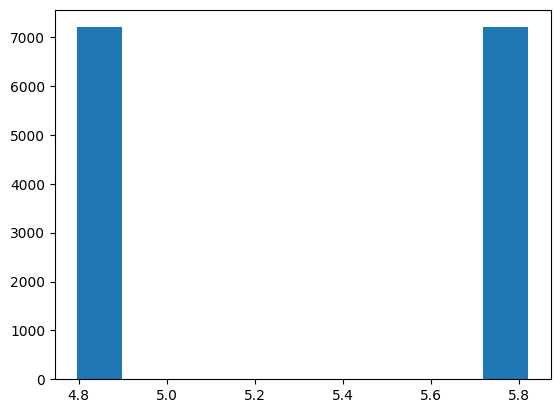

In [32]:
plt.hist(margins)

In [33]:
set(margins)

{4.797130584716797,
 4.797131538391113,
 4.79713249206543,
 4.797133445739746,
 4.7971343994140625,
 4.797135353088379,
 4.797136306762695,
 4.797137260437012,
 4.797138214111328,
 4.7971391677856445,
 4.797140121459961,
 4.797141075134277,
 4.797142028808594,
 4.79714298248291,
 4.797143936157227,
 4.797144889831543,
 5.821364402770996,
 5.8213653564453125,
 5.821366310119629,
 5.821367263793945,
 5.821368217468262,
 5.821369171142578,
 5.8213701248168945,
 5.821371078491211,
 5.821372032165527,
 5.821372985839844,
 5.82137393951416,
 5.821374893188477,
 5.821375846862793,
 5.821376800537109,
 5.821377754211426,
 5.821378707885742,
 5.821379661560059}

In [28]:
out.topk(k=2).values[0] - out.topk(k=2).values[1]

tensor(5.8214, grad_fn=<SubBackward0>)

In [158]:
loss = lambda x: -t.log(t.exp(x[0]) / t.exp(x).sum())

In [159]:
max_loss = 0
for _ in tqdm(range(1000000)):
    err = t.randn_like(out)#.sign() * 11
    err = err / err.norm() * 8.3
    max_loss = max(max_loss, loss(out + err).item())
loss(out).item(), max_loss

100%|██████████| 1000000/1000000 [00:20<00:00, 49350.99it/s]


(0.0010046042734757066, 0.0495346337556839)

In [31]:
model = model.fold_linear()
# ideal = ideal.fold_linear()
ln1, rn1, un1 = model.get_neurons()
ln2, rn2, un2 = ideal.get_neurons()
ln1, rn1, un1 = ln1[:,:, part_idxs], rn1[:,:, part_idxs], un1[:,:, part_idxs]
ln2, rn2, un2 = ln2[:,:, part_idxs], rn2[:,:, part_idxs], un2[:,:, part_idxs]
ln_noise = t.randn_like(ln1)
ln_noise = ln_noise / ln_noise.norm() * (ln1 - ln2).norm()
rn_noise = t.randn_like(rn1)
rn_noise = rn_noise / rn_noise.norm() * (rn1 - rn2).norm()
un_noise = t.randn_like(un1)
un_noise = un_noise / un_noise.norm() * (un1 - un2).norm()
ln3, rn3, un3 = ln2 + ln_noise, rn2 + rn_noise, un2 + un_noise

NameError: name 'part_idxs' is not defined

In [15]:
un1.norm(), un2.norm() 

(tensor(27.0105), tensor(26.9070))

In [20]:
noise_model = copy.deepcopy(model)
noise_model.embedding_left = nn.Parameter(ln3)
noise_model.embedding_right = nn.Parameter(rn3)
noise_model.unembedding = nn.Parameter(un3.mT)

In [21]:
test_loss(noise_model, data)

{'G0_loss': tensor([0.2678]),
 'G0_loss_std': tensor([0.1247]),
 'G0_acc': tensor([1.])}

In [57]:
test_loss(noise_model, data), test_loss(ideal, data),  test_loss(model, data)

({'G0_loss': tensor([0.1731]),
  'G0_loss_std': tensor([0.1883]),
  'G0_acc': tensor([0.9990])},
 {'G0_loss': tensor([0.1231]),
  'G0_loss_std': tensor([0.0968]),
  'G0_acc': tensor([1.])},
 {'G0_loss': tensor([0.0296]),
  'G0_loss_std': tensor([0.0080]),
  'G0_acc': tensor([1.])})

In [29]:
model_dist2(model, ideal)#, irrep_idx_dict, vecs)

tensor(151.1256)

In [28]:
sorted(dist.tolist())

TypeError: 'float' object is not iterable

In [44]:
model_dist_parted(model, ideal, irrep_idx_dict, vecs)

1d-0
l diff tensor(0.1423)
r diff tensor(0.1301)
u diff tensor(0.1309)
l norm tensor(37.6832)
r norm tensor(37.6227)
u norm tensor(8.6710)
12.21975326538086
4d-1
l diff tensor(0.5003)
r diff tensor(0.4084)
u diff tensor(2.0580)
l norm tensor(37.3536)
r norm tensor(37.2156)
u norm tensor(6.8900)
159.40463256835938
4d-1
l diff tensor(0.)
r diff tensor(0.)
u diff tensor(1.4427)
l norm tensor(8.8416)
r norm tensor(8.7849)
u norm tensor(1.4427)
25.430316925048828


197.05470275878906

In [32]:
_, _, un1 = model.get_neurons(True)
_, _, un2 = ideal.get_neurons(True)

In [43]:
((un1 - un2).norm(dim=0))[part_idxs].max() #/ un1.norm(dim=0))[part_idxs]

tensor(0.5175)

In [61]:
(ideal.unembedding - model.unembedding)[0].norm(dim=1)

tensor([3.9519e-01, 1.9263e+00, 2.7491e-02, 0.0000e+00, 2.0834e-03, 2.9060e-02,
        3.0195e-01, 4.8089e-01, 1.3822e+00, 2.9299e-01, 5.6391e-04, 1.7642e+00,
        4.3101e-01, 2.3929e-01, 3.8706e-04, 1.8467e-01, 3.0984e-01, 6.9950e-03,
        1.4025e+00, 1.1464e-01, 0.0000e+00, 2.8585e-01, 1.7904e+00, 2.1838e-01,
        1.2053e-04, 4.7698e-01, 1.7771e+00, 4.6449e-02, 1.2915e-04, 1.2651e-01,
        4.9187e-03, 1.3275e-01, 1.5971e+00, 8.5666e-02, 4.7559e-01, 0.0000e+00,
        9.9433e-02, 3.8776e-01, 1.8291e+00, 8.8188e-01, 9.8395e-02, 1.2016e-04,
        0.0000e+00, 4.6339e-01, 3.0990e-02, 1.6035e-02, 4.7704e-01, 1.9921e-03,
        4.4426e-01, 3.2006e-01, 2.2652e-01, 1.8414e+00, 1.0796e+00, 1.7409e-02,
        8.8652e-02, 4.2277e-01, 1.8674e+00, 1.2950e-03, 4.2510e-01, 4.7889e-01,
        1.8257e+00, 8.6694e-02, 8.8028e-02, 4.6159e-01, 1.5211e+00, 1.6752e+00,
        1.5701e-02, 1.8629e+00, 4.4153e-01, 3.2458e-01, 1.3208e-03, 4.6803e-02,
        0.0000e+00, 1.5985e-03, 1.2449e+

In [43]:
ideal.unembedding[0, part_idxs[4], :15], model.unembedding[0, part_idxs[4], :15]

(tensor([-0.9858,  0.2464,  0.2464,  0.2464,  0.2464, -0.9858, -0.9858,  0.2464,
          0.2464,  0.2464,  0.2464, -0.9858,  0.2464,  0.2464,  0.2464],
        grad_fn=<SliceBackward0>),
 tensor([-0.9570,  0.1998,  0.2163,  0.2846,  0.2874, -1.0399, -1.0421,  0.2721,
          0.2724,  0.2598,  0.1809, -0.9766,  0.2939,  0.1614,  0.2129],
        grad_fn=<SliceBackward0>))

In [37]:
irrep_idx_dict['4d-1'].index(88)

65

In [38]:
b_labels[65], c_labels[65]

(tensor(5, dtype=torch.int32), tensor(5, dtype=torch.int32))

In [12]:
from coset_bounds import model_dist as cdist

In [15]:
cdist(model, ideal)

l diff tensor(0.5003)
r diff tensor(0.4084)
u diff tensor(2.0830)
l norm tensor(37.6832)
r norm tensor(37.6227)
u norm tensor(8.9174)


tensor(164.9650)

In [136]:
ideal.unembedding[0,5,:].norm(), model.unembedding[0,5,:].norm()

(tensor(0., grad_fn=<LinalgVectorNormBackward0>),
 tensor(0.1013, grad_fn=<LinalgVectorNormBackward0>))

In [148]:
(ideal.unembedding[0] - model.unembedding[0]).norm(dim=1).argmax()

tensor(88)

In [150]:
ideal.unembedding[0,88].norm(), model.unembedding[0,88].norm()

(tensor(0., grad_fn=<LinalgVectorNormBackward0>),
 tensor(1.2796, grad_fn=<LinalgVectorNormBackward0>))

In [154]:
test_loss(ideal, data), test_loss(model, data)

({'G0_loss': tensor([0.1231]),
  'G0_loss_std': tensor([0.0968]),
  'G0_acc': tensor([1.])},
 {'G0_loss': tensor([0.0296]),
  'G0_loss_std': tensor([0.0080]),
  'G0_acc': tensor([1.])})

In [163]:
ideal(t.tensor([[10, 15]])).max()

tensor(15.5970, grad_fn=<MaxBackward1>)

In [173]:
irrep_model = copy.deepcopy(ideal)
irrep_name = '1d-0'
irrep_model.embedding_left.data = ideal.embedding_left[:,:,irrep_idx_dict[irrep_name]]
irrep_model.embedding_right.data = ideal.embedding_right[:,:,irrep_idx_dict[irrep_name]]
irrep_model.unembedding.data = ideal.unembedding[:,irrep_idx_dict[irrep_name]]

In [171]:
test_loss(irrep_model, data)

{'G0_loss': tensor([0.2198]),
 'G0_loss_std': tensor([4.2085e-07]),
 'G0_acc': tensor([1.])}

In [180]:
irrep_model(t.tensor([[11, 17]]))

tensor([[[-3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460,  3.8460,
          -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460,
           3.8460, -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,
           3.8460,  3.8460, -3.8460,  3.8460, -3.8460, -3.8460,  3.8460,
           3.8460, -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,
           3.8460,  3.8460, -3.8460, -3.8460,  3.8460,  3.8460, -3.8460,
          -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460, -3.8460,
           3.8460,  3.8460, -3.8460, -3.8460,  3.8460,  3.8460, -3.8460,
          -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460,  3.8460,
          -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460,
           3.8460, -3.8460,  3.8460, -3.8460, -3.8460,  3.8460,  3.8460,
          -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460,
           3.8460, -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,
           3.8460,  3.8460, -3.8460, -3.8460,  3.84

In [183]:
irrep_model.unembedding[0,:,:10]

tensor([[-0.5594,  0.5594,  0.5594, -0.5594, -0.5594,  0.5594,  0.5594, -0.5594,
         -0.5594,  0.5594],
        [-0.5598,  0.5598,  0.5598, -0.5598, -0.5598,  0.5598,  0.5598, -0.5598,
         -0.5598,  0.5598],
        [-0.0010,  0.0010,  0.0010, -0.0010, -0.0010,  0.0010,  0.0010, -0.0010,
         -0.0010,  0.0010]], grad_fn=<SliceBackward0>)

In [48]:

irrep_bases = dict()
for name, irrep in irreps.items():
    irrep = einops.rearrange(irrep, 'N d1 d2 -> N (d1 d2)')
    U, S, V = t.svd(irrep)
    nonzero = S > 1e-5
    irrep_bases[name] = U[:,nonzero]

# Dimension of subspace spanned by each irrep
for k, v in irrep_bases.items():
    print(k, v.shape)

1d-0 torch.Size([120, 1])
4d-0 torch.Size([120, 16])
5d-0 torch.Size([120, 25])
6d-0 torch.Size([120, 36])
5d-1 torch.Size([120, 25])
4d-1 torch.Size([120, 16])
1d-1 torch.Size([120, 1])


In [54]:
# Proportion of variance explained by each irrep, for each neuron
ures_expl = dict()
ubias_expl = dict()

for name, basis in irrep_bases.items():
    ures_expl[name] = (basis.H @ ures_big).norm(dim=0)**2 / (ures_big.norm(dim=0)**2 + 1e-8)
    ubias_expl[name] = (basis.H @ ubias).norm(dim=0)**2 / (ubias.norm(dim=0)**2 + 1e-8)

In [56]:
ures_expl

{'1d-0': tensor([2.2703e-03, 2.3903e-06, 2.2074e-03, 3.8170e-03, 5.3694e-06, 4.7517e-04,
         1.3478e-05, 9.9386e-12, 9.7257e-03, 1.0623e-02, 2.3099e-05, 8.9464e-04,
         5.6647e-04, 1.6329e-03, 2.1714e-02, 7.0234e-04, 4.1935e-04, 1.1982e-04,
         5.5475e-05, 8.4600e-03, 1.2267e-03, 2.9535e-03, 5.9241e-09, 3.3240e-03,
         5.1312e-03, 1.4887e-05, 9.2031e-12]),
 '4d-0': tensor([0.1483, 0.1038, 0.0868, 0.1295, 0.0929, 0.0817, 0.1756, 0.1694, 0.1428,
         0.1229, 0.1398, 0.1425, 0.1346, 0.0456, 0.1851, 0.1676, 0.1807, 0.0891,
         0.0623, 0.1595, 0.1011, 0.1832, 0.1181, 0.1393, 0.0894, 0.1435, 0.1533]),
 '5d-0': tensor([0.2572, 0.2210, 0.1895, 0.3072, 0.2438, 0.2120, 0.1813, 0.2150, 0.1564,
         0.2704, 0.2162, 0.2885, 0.2417, 0.2044, 0.1561, 0.0952, 0.1882, 0.2290,
         0.2489, 0.1922, 0.2993, 0.1563, 0.3368, 0.2274, 0.2981, 0.2231, 0.1733]),
 '6d-0': tensor([0.3363, 0.2904, 0.3211, 0.2642, 0.3670, 0.3065, 0.2789, 0.3254, 0.3593,
         0.2445, 0.2884, 0

In [57]:
ubias_expl

{'1d-0': tensor([0.9835]),
 '4d-0': tensor([0.0027]),
 '5d-0': tensor([0.0015]),
 '6d-0': tensor([0.0055]),
 '5d-1': tensor([0.0019]),
 '4d-1': tensor([0.0012]),
 '1d-1': tensor([0.0038])}